In [25]:
import time
import numpy as np
import glob
from matplotlib import pyplot as plt
import random
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import pickle
from joblib import dump, load


In [26]:
data_dir = "E:\\ICE_TRAINING\\"
file_list = glob.glob(data_dir + "*90.npy" )
random.shuffle(file_list)
#file_list = file_list[0:200]
print(str(len(file_list)) + " files found")
# parameters
# batch_size = 100
ash_ratio = 6
n_features = 16
ash_pixel_sample_size = 512
feature_radius = 15


97 files found


In [27]:
def rescale(array):
    mu = np.nanmean(array)
    va = np.nanvar(array)
    new_array = (array-mu)/va
    return new_array

def temperature_rescale(array):
    return (array-200)/100.

def reflectance_rescale(array):
    return array/100.

def get_local_matrix(indx,jndx,array,size): # returns matrix centred at indx, jndx of size size. cuts off at edge
    array_shape = np.shape(array)
    r1 = indx - size
    r2 = indx + size + 1
    c1 = jndx - size
    c2 = jndx + size + 1
    if r1 < 0:
        r1 = 0
    if c1 < 0:
        c1 = 0
    if r2 > array_shape[0]:
        r2 = array_shape[0] + 1
    if c2 > array_shape[0]:
        c2 = array_shape[0] + 1

    return array[r1:r2,c1:c2]

In [28]:
# my_rand_matrix = np.zeros((20,20))
# for w in range(20):
#     for q in range(20):
#         my_rand_matrix[w,q] = random.randint(0,100)
# array_shape2 = np.shape(my_rand_matrix)
# array_shape2_x = array_shape2[0]
# my_local_matrix = get_local_matrix(18,18,my_rand_matrix,5)
#

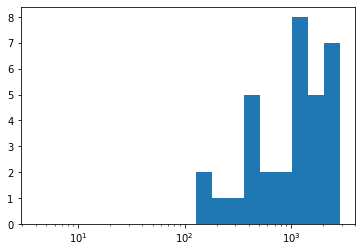

Number with under 256 ash pixels: 3
Number with over 256 ash pixels: 94


In [29]:
def get_local_T11_max(i,j,array,radius):
    try:
        return np.nanmax(get_local_matrix(i,j,array,radius))
    except ValueError:
        ## print("Value Error Encountered in Calculating Max")
        return array[i,j]

def get_local_T11_variance(i,j,array,radius): # this actually does std now to improve the spread of values
    try:
        return np.nanstd(get_local_matrix(i,j,array,radius))
    except ValueError:
        ## print("Value Error Encountered in Calculating Var")
        return 0.

T11_max_feature = True
T11_var_feature = True
BTD_feature = True
Time_feature = False
Noise_feature = False

if T11_max_feature:
    n_features += 1
if T11_var_feature:
    n_features += 1
if BTD_feature:
    n_features += 1
if Time_feature:
    n_features += 1
if Noise_feature:
    n_features += 1

super_sampled_train_data = np.zeros((len(file_list),(1+ash_ratio)*ash_pixel_sample_size,n_features))
super_sampled_val_data = np.zeros((len(file_list),(1+ash_ratio)*ash_pixel_sample_size))
ash_pixel_count_list = []

for idx, file in enumerate(file_list):
    file_data = np.load(file)
    train_data = np.nan_to_num(file_data[128:384,128:384,:16])
    val_data = np.nan_to_num(file_data[128:384,128:384,16])
    # file_hour = int(file.split("_")[1][:2])/24.
    train_data_n = np.copy(train_data)
    noise_matrix = np.random.rand(256,256)
    # rescale everything
    for j in range(0,6):
        train_data_n[:,:,j] = reflectance_rescale(train_data[:,:,j])
    for j in range(6,16):
        train_data_n[:,:,j] = temperature_rescale(train_data[:,:,j])

    # locate pixels inside polygon

    ns,ms = np.where(val_data==1.0)
    ash_pixel_count = len(ns)
    ash_pixel_count_list.append(ash_pixel_count)

    #locate pixels outside polygon

    js,ks = np.where(val_data != 1.0)
    not_ash_pixel_count = len(js)

    if ash_pixel_count < ash_pixel_sample_size:

        random_pixel_index_list = [x%ash_pixel_count for x in range(ash_pixel_sample_size)]
        sample_ash_coords = [(ns[l],ms[l]) for l in random_pixel_index_list]

        random_not_ash_pixel_list = random.sample(range(not_ash_pixel_count), ash_pixel_sample_size*ash_ratio)
        sample_not_ash_coords = [(js[l],ks[l]) for l in random_not_ash_pixel_list]

    elif not_ash_pixel_count < ash_ratio*ash_pixel_sample_size:

        random_pixel_index_list = random.sample(range(ash_pixel_count), ash_pixel_sample_size)
        sample_ash_coords = [(ns[l],ms[l]) for l in random_pixel_index_list]

        random_not_ash_pixel_list = [x%ash_pixel_count for x in range(ash_ratio*ash_pixel_sample_size)]
        sample_not_ash_coords = [(js[l],ks[l]) for l in random_not_ash_pixel_list]

    else:
        random_pixel_index_list = random.sample(range(ash_pixel_count), ash_pixel_sample_size)
        sample_ash_coords = [(ns[l],ms[l]) for l in random_pixel_index_list]

        random_not_ash_pixel_list = random.sample(range(not_ash_pixel_count), ash_pixel_sample_size*ash_ratio)
        sample_not_ash_coords = [(js[l],ks[l]) for l in random_not_ash_pixel_list]




    # initialise training and validation vectors

    sampled_train_data = np.zeros(((1+ash_ratio)*ash_pixel_sample_size, n_features))
    sampled_val_data = np.zeros((1+ash_ratio)*ash_pixel_sample_size)

    for u in range(ash_pixel_sample_size):
        ru = sample_ash_coords[u][0] # random ash row
        cu = sample_ash_coords[u][1] # random ash column
        sampled_train_data[u, :16] = train_data_n[ru, cu,:]
        if T11_max_feature:
            sampled_train_data[u, 16] = get_local_T11_max(ru, cu,train_data_n[:,:,14],2*feature_radius)
        if T11_var_feature:
            sampled_train_data[u, 17] = 100.*get_local_T11_variance(ru, cu,train_data_n[:,:,14],feature_radius)
        if BTD_feature:
            sampled_train_data[u, 18] = 10.*(train_data_n[ru,cu,13]-train_data_n[ru,cu,14])
        if Noise_feature:
            sampled_train_data[u,19] = noise_matrix[ru, cu]
        sampled_val_data[u] = 1

    for v in range(ash_ratio*ash_pixel_sample_size):
        rv = sample_not_ash_coords[v][0] # random not ash row
        cv = sample_not_ash_coords[v][1] # random not ash column
        sampled_train_data[v+ash_pixel_sample_size,:16] = train_data_n[rv, cv, :]
        if T11_max_feature:
            sampled_train_data[v+ash_pixel_sample_size, 16] = get_local_T11_max(rv, cv, train_data_n[:,:,14], 2*feature_radius)
        if T11_var_feature:
            sampled_train_data[v+ash_pixel_sample_size, 17] = 100.*get_local_T11_variance(rv, cv,train_data_n[:,:,14],feature_radius)
        if BTD_feature:
            sampled_train_data[v+ash_pixel_sample_size, 18] = 10.*(train_data_n[rv,cv,13]-train_data_n[rv,cv,14])
        if Noise_feature:
            sampled_train_data[v+ash_pixel_sample_size,18] = noise_matrix[rv, cv]
        sampled_val_data[v+ash_pixel_sample_size] = 0

    super_sampled_val_data[idx, :] = sampled_val_data
    super_sampled_train_data[idx] = sampled_train_data


    #plt.imsave("poly_" + str(idx) + "_" + str(ash_pixel_count )+ ".png",val_data , cmap = "binary")
    #plt.imsave("IR_" + str(idx) + ".png",train_data_n[:,:,15]-train_data_n[:,:,14] , cmap = "RdBu")
bins = 2**(np.arange(2,12,0.5))
plt.hist(ash_pixel_count_list,bins = bins)
plt.xscale("log")
plt.show()

print("Number with under 256 ash pixels: " + str(len([x for x in ash_pixel_count_list if x<256])))
print("Number with over 256 ash pixels: " + str(len([x for x in ash_pixel_count_list if x>256])))




Commencing training...
Training complete
Time taken: 21.806137800216675s
Confusion matrix, without normalization
[[74043   512]
 [ 3946  8411]]
Normalized confusion matrix
[[0.993 0.007]
 [0.319 0.681]]


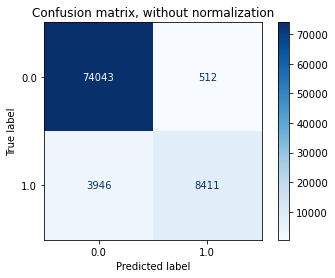

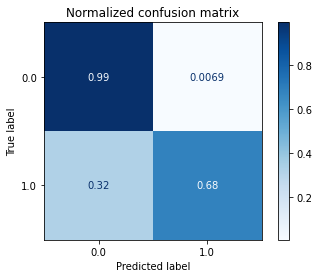

In [30]:

X = super_sampled_train_data.reshape(((1+ash_ratio)*ash_pixel_sample_size*len(file_list),n_features))
y = super_sampled_val_data.reshape((1+ash_ratio)*ash_pixel_sample_size*len(file_list))
# remove useless datapoints

# useless_points = np.where(X[:,0]==0.0)
#
# print("Number of useless data points: " + str(len(useless_points)))
# for idx in useless_points[-1]:
#     if idx%1000 == 0:
#         print(idx)
#     np.delete(X,idx,0)
#     np.delete(y,idx,0)


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier

print("Commencing training...")
t0 = time.time()

#classifier = svm.SVC(kernel="poly", C=1,verbose = 1,
                     #probability = True,cache_size=4000).fit(X_train, y_train)

#classifier = AdaBoostClassifier(n_estimators=100,n_jobs = -1).fit(X_train, y_train)

classifier = RandomForestClassifier(n_estimators=32).fit(X_train, y_train)

#classifier = HistGradientBoostingClassifier(verbose = 1).fit(X_train, y_train)

print("Training complete")
t1 = time.time()
dt = t1-t0
np.set_printoptions(precision=3)
print("Time taken: " +str(dt) + "s")

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()


In [31]:
Test = False
# Lets test it
if Test:
    test_dir = "D:\\Small_Test\\"
    test_file_list = glob.glob(test_dir + "*.npy" )

    for idx, file in enumerate(test_file_list):
        print("Processing file " + str(idx+1) + " of " + str(len(test_file_list)))
        file_data = np.load(file)
        train_data = np.nan_to_num(file_data[:,:,:16])
        val_data = np.nan_to_num(file_data[:,:,16])
        train_data_n = np.copy(train_data)

        # rescale everything
        for j in range(0,6):
            train_data_n[:,:,j] = reflectance_rescale(train_data[:,:,j])
        for j in range(6,16):
            train_data_n[:,:,j] = temperature_rescale(train_data[:,:,j])
        predict_data = np.zeros((512,512))
        t0 = time.time()
        for a in range(512):
            if a in range(0,512,16):
                print(str(np.round((100*(a)/512),2)) + " % complete")
            for b in range(512):
                empty_data = np.zeros(n_features)
                band_values = train_data_n[a,b,:]
                empty_data[:16] = band_values
                if T11_max_feature:
                    empty_data[16] = get_local_T11_max(a,b,train_data_n[:,:,14],2*feature_radius)
                if T11_var_feature:
                    empty_data[17] = 100.*get_local_T11_variance(a,b,train_data_n[:,:,14],feature_radius)
                if BTD_feature:
                    empty_data[18] = 10.*(train_data_n[a,b,13]-train_data_n[a,b,14])
                if Noise_feature:
                    empty_data[19] = random.uniform(0,1)
                classify_vector = empty_data.reshape(1,-1)
                prob = classifier.predict_proba(classify_vector)
                predict_data[a,b] = prob[0][0]
        t1 = time.time()
        dt = t1 - t0
        print("Time taken: " +str(np.round(dt,2)) + "s")
        d_len = len(data_dir)
        file_tag = file[14:]

        plt.imsave("poly_" + str(idx) + "_" + str(file_tag) + "_.png",val_data , cmap = "binary")
        # predict_data[0,0] = 1.0  # this is for scaling purposes
        # predict_data[-1,-1] = 0.0
        plt.imsave("predict_proba_" + str(idx) + "_" + str(file_tag) + "_random_forest" +  "_.png",predict_data , cmap = "seismic" )
        plt.imsave("IR_" + str(idx) + "_" + str(file_tag) + ".png",train_data_n[:,:,14] , cmap = "binary")
        plt.imsave("BTD_" + str(idx) +"_" + str(file_tag) + ".png",train_data[:,:,13]-train_data[:,:,14] , cmap = "seismic")


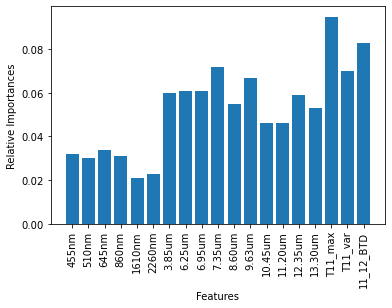

In [32]:
model_name = "RF_ice_nishi_32.sav"
pickle.dump(classifier,open(model_name,"wb"))


importances = list(np.round(classifier.feature_importances_,3))
bands = [str(x) for x in range(1,17)]
band_labels = ["455nm", "510nm", "645nm", "860nm", "1610nm",
               "2260nm", "3.85um","6.25um", "6.95um", "7.35um",
               "8.60um", "9.63um", "10.45um", "11.20um",
               "12.35um", "13.30um", "T11_max","T11_var","11_12_BTD"] # "noise"]
# for idx, g in enumerate(importances):
#     print(str(bands[idx]) + ": " + str(g))

plt.bar(band_labels,importances)
plt.xticks(band_labels,rotation = "vertical")
plt.ylabel("Relative Importances")
plt.xlabel("Features")
plt.show()

In [33]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 58.247 seconds


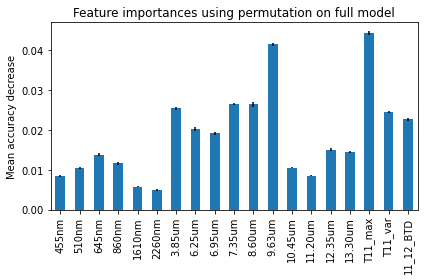

In [34]:
import pandas as pd
forest_importances = pd.Series(result.importances_mean,index = band_labels)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [35]:
#dec_path = classifier.decision_path(X_test[20,:].reshape(1,-1))
# estimator = classifier.estimators_[5]
# from sklearn import tree
# tree.export_graphviz(estimator, out_file = "my_tree.dot")

In [36]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from matplotlib import pyplot as plt
import glob
# img_list = glob.glob(f"D:\\NISHINOSHIMA_IMAGES\\predict_proba*.png")
# for img_name in img_list:
#     img = plt.imread(img_name)
#     img_denoised = denoise_tv_chambolle(img[:,:,2])
#     img_denoised_scaled = 255*img_denoised
#     img_thresholded = 255*np.sign(img[:,:,2]-0.6)
#     plt.imsave(f"{img_name[:len(img_name)-3]}_masked.png",img_thresholded,cmap = "Oranges")
#
